In [212]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [213]:
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn'])

# Chapter 4. Linear Models

# 1. Why linear regression?

Because it can make useful approximations, even though mechanistically it is virtually always incorrect.

***

# 2. Why Normal?

A. **Because Normal distributions are easy to calculate.** Given a mean and a variance the probability distribution can be calculated with a single equation.

B. **Ontological Perspective:** Normal distributions are ubiquitous in nature

C. **Epistemological Perspective:** normal distributions are very conservative. Selecting a normal distribution implies that you know that the data have a mean and a variance. Further, for a given mean and variance, the normal distribution covers a larger area than any other probability distribution.

### B. The Ontological Perspective

**Normal by Addition**

Normal distributions are so common on nature because any process that adds small fluctuations together will produce observations that follow a normal distribution regardless of the process that produced the observaions.

In the code example below, if you flip a coin and take one step forward for heads and one step backward for tails, you will end up with data that resemble a normal distribution after only a few steps (e.g. 16)

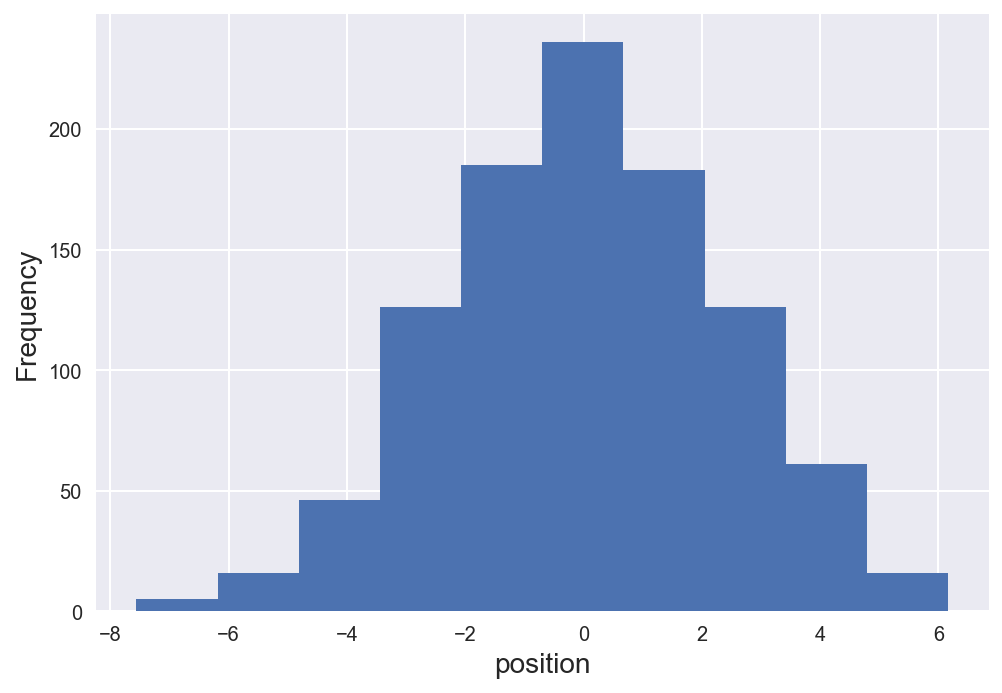

In [3]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
plt.hist(pos)
plt.xlabel('position', fontsize=14)
plt.ylabel('Frequency', fontsize=14);

**Normal by multplication**

* Products of *small* deviations are approximately normal, because multiplication of small numbers is approximately equal to addition. Eg. 

    * 1.1 * 1.1 = 1.21
    * 1.1 + 1.1 = 1.2

* Products of *large* deviations are exactly normal on the *log* scale (aka log-normal). This is because multiplication of numbers is equivalent to addition on the log scale.

**Summary of the Ontological Perspective**

Variations in height, measurement errors, and the velocity of molecules all follow Normal distributions. Normal distributions are so widespread because many of the patterns that we observe are the consequence of the addition of a large number of fluctuations. Once you have added together a large number of fluctuations you shed all information about the underlying flucuations themselves except for their mean and variance.

One consequence of using Normal distributions in inference is that you cannot reliably identify micro-processes (See **The Epistemological Perspective**). Despite this, the Normal distribution is useful because we can make accurate predictions without understanding any of the underlying processes.

***

### C. The Epistemological Perspective

Another justification for using a Normal distribution--and one that also helps explains why it is often a poor choice--is that it represents a particular state of ignorance. If all we are willing to claim about the process is that it will produce data with a mean and a variance, then the Normal distribution is the most consistent distribution with our assumptions.

That is to say that the Normal distribution is the most natural way to express our ignorance, because if all we are willing is to assume that a measure has finite variance, the Normal distribution is the shape that can be realized in the *most number of ways* without introducing any other assumptions. That is to say that the Normal distribution is the distribution that is most consistent with our assumptions, or rather our golem's assumptions. Linear regression assumes that errors are normally distributed--that is, the error of the model is the sum of a large number of processes that we have not quantified and the only thing that we are willing to say about the errors is that they have a mean and a variance. Of course, if you don't think that the distribution should be Normal that implies that you know something that you should tell your golem. Indeed, if we *did* know more about the errors we would likely be better suited using a different kind of distribution to model the errors.


***

# 3. A Linear Model of Height

I have skipped forward a bunch of sections and start at 4.4. We are modeling the height of a population of adults. The data are presented below:

In [4]:
dat = pd.read_csv('Data/Howell1.csv', sep=';', header=0)

# Filter to adults (18 or older) only
adults = dat[dat.age >= 18]

adults.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

### 3.1 Defining the Model

The model for height is described below:


Likelihood: $h_i \sim Normal(\mu, \sigma)$

Linear model: $\mu_i = \alpha + \beta x_i$

$\alpha$ prior: $\alpha \sim Normal(178, 100)$

$\beta$ prior: $\beta \sim Normal(0, 10)$

$\sigma$ prior: $\sigma \sim Uniform(0, 50)$


Where $x$ is weight.

***

* Recall that $\alpha$ is also commonly denoted $\beta_0$

* Note that the mean $\mu$ is no longer a parameter to be estimated. Instead it is a *deterministic* relationship (there is no ~ in it). Once we know $\alpha$, $\beta$, and $x_i$, we know $\mu_i$.

* The remaining three lines are the priors. They are all weak priors relative to the amount of data that we will be working with.

    * $\alpha$, the parameter for the y-intercept (aka the mean height) has a standard deviation of 100. I.e., it is actually possible to have negative heights according to this prior. However, weak priors are frequently used for intercepts since they have little to no interpretability without studying any $\beta$ parameters (you want your intercept to be flexible in order to accomodate different slopes ($\beta$).
    
    * $\beta$, the slope parameter is Normally distributed with a mean of 0 and an sd of 10. A mean of 0 implies that there is no relationship between weight and height. These parameters also mean that a negative relationship between height and weight is as likely as a positive one.
    
    * $\sigma$, the parameter for the population standard deviation is uniformly distributed between 0 and 50. This is a very weak prior for $\sigma$, as a Normal distribution with mean ~178 and sd ~25 will easily produce mean population heights between 150 - 200cm.  

The model described above is implemented in the code cell below.

Instead of using the quadratic approximation that is used in the textbook, we can use PyMC3's *sampler method* (e.g., MCMC).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us (it will assign NUTS). PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN 'jitter+adapt_diag', which start with an identity mass matrix and then adapt a diagonal based on the variance of the tuning samples.

Notice that the variable $\mu$ is defined as `alpha + beta * adults.weight` in a single line. If we want the trace to contain $\mu$ we can write it as a deterministic varible. The computating will be exactly the same. The only diference is that $\mu$ will be accessible in the trace.

In [61]:
# Code 4.38 and 4.39

with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    # mu = alpha + beta * adults.weight
    mu = pm.Deterministic('mu', alpha + beta * adults.weight)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=adults.height)
    trace_4_3 = pm.sample(1000, tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1234.30draws/s]


***

#### Philosophical Digression: Choosing a Prior

In the model above, the priors may be viewed as a little silly. For example, there is an equal probability of a negative relationship between height and weight as there is positive. Or that height can be negative. In these cases the priors are relatively harmless because they are weak compared to the amount of data that are available. 

It is a misconception that there is a uniquely correct prior that must be used lest the model be rendered invalid. There is no more a correct prior than there is a correct likelihood. Statistical models are machines for inference; and just like machines, many will work---though some better than others.

Priors encode our starting view about the world before observing the data. They allow us to examine how different starting "views" could affect the posterior. Priors can be *wrong*, but only in the sense that a certain kind of hammer can be wrong for building a table. There is an illusion that default procedures are more objective than those than require user choice. If that is true, then all "objective" means is that everyone does the same thing---it carries no guarantees of realism or accuracy.

***

## 3.2 Interpreting the model fit

There are two main ways of interpreting model fit.

1. **Printing a table of parameter estimates.** In general models can't be well understood by simply looking at a table of estimates---beyond a few parameters the models become too complex. The implementation of this is given in code 4.40.

2. **Plotting the posterior distributions.** This produces much better understanding of the model and is discussed in more detail below.


In [65]:
# Code 4.40
pm.summary(trace_4_3, alpha=.11).round(2)[:3]    # Only print the first 3 parameters; alpha, beta, and sigma (ignore the mu parameters)

mean    sd  mc_error  hpd_5.5  hpd_94.5    n_eff  Rhat
alpha  113.89  1.85      0.05   110.97    116.79  1466.15   1.0
beta     0.90  0.04      0.00     0.84      0.97  1465.50   1.0
sigma    5.10  0.19      0.00     4.80      5.41  1852.16   1.0

### Plotting models

Plotting is better than a simple table of estimates. You can see all of your data and you can more easily assess model fit. Below I provide three different types of plots for comparison. In the next section I present even more (and more elaborate) plots to help interpret the model results.

1. In the first plot we simply plot all of our data and the MAP line. The MAP line is just the posterior mean---the most plausible line in the infinite universe of possible lines the posterior distribution has considered (in this case the MAP line is equivalent to the maximum likelihood line because the priors are so weak).

    Plots like these are good at showing slope, but they are not good at communicating uncertainty. Recall that the posterior considers every possible combination of the near-infinite $\alpha$ and $\beta$ parameters. There could easily be other lines that are *almost* as plausible as the MAP line. 

2. In the second, we visualize the uncertainty that we would get around the MAP estimate if we were to take several lines sampled from the posterior distribution. We can see that with increasing data, the uncertainty becomes more narrow.

3. The third plot is a trace of the parameters. This is not covered yet in the book, but is a valuable diagnostic.

***

#### Plot 1

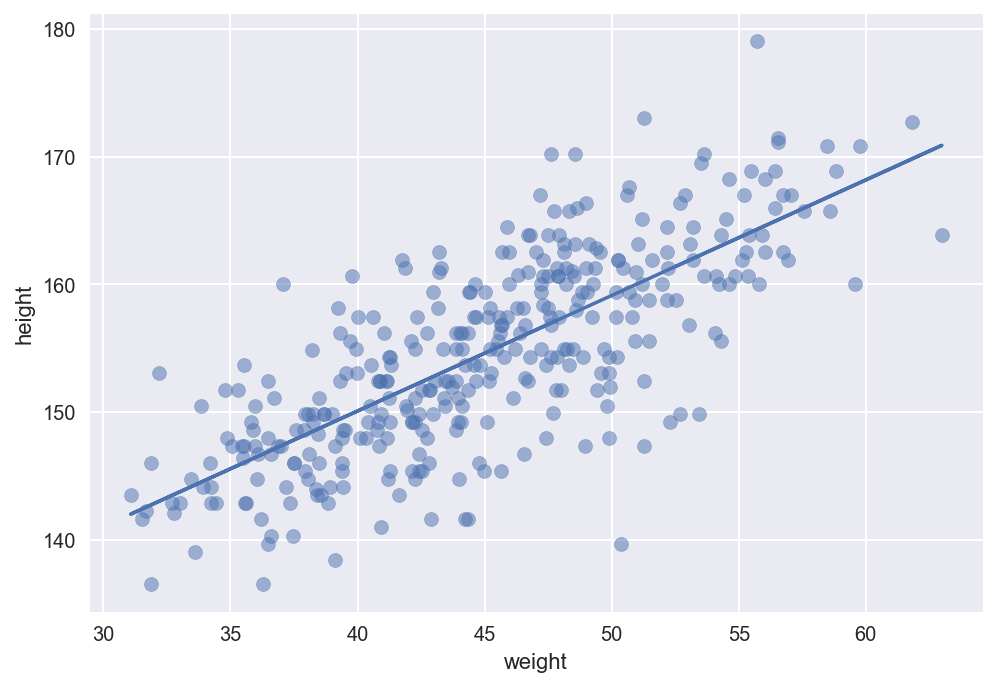

In [122]:
# Plot 1; code 4.45

plt.scatter(adults.weight, adults.height, alpha = 0.5)
plt.plot(adults.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * adults.weight)
plt.xlabel('weight');
plt.ylabel('height');

***

#### Plot 2

As described above, Plot 1 does a poor job of communicating uncertainty. To better visualize this uncertainty we can extract samples of each parameter from the posterior and plot each of these lines. If we averaged over all of these samples we would get something close to the MAP line, but just seeing the spread of the lines itself is useful in how we interpret the model's uncertainty.

In the code chunks below we will fit the same model using different amounts of data:

In [461]:
# Code 4.48

N = [10, 50, 150, 352]
chains = {}

# Fit 4 models each with different amounts of data and save the traces in a dict.
for i in range(len(N)):
    with pm.Model() as m_N:
        # These parameters are the same as before
        alpha = pm.Normal('alpha', mu=178, sd=100)
        beta = pm.Normal('beta', mu=0, sd=10)
        sigma = pm.Uniform('sigma', lower=0, upper=50)

        # These parameters are the same as before, but only use a fraction of the data.
        mu = pm.Deterministic('mu', alpha + beta * adults.weight[:N[i]])
        height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=adults.height[:N[i]])
        trace_N = pm.sample(1000, tune=1000)
    
    # Store each chain in a dictionary:
    chain_N = trace_N[100:]
    chains.update({'chain_' + str(i) : chain_N})

chain = trace_4_3[100:]    # Burn the first 100 samples


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1136.27draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:09<00:00, 871.51draws/s]
The acceptance probability does not match the target. It is 0.7079617421996871, but should be close to 0.8. Try to increase the number of tuning st

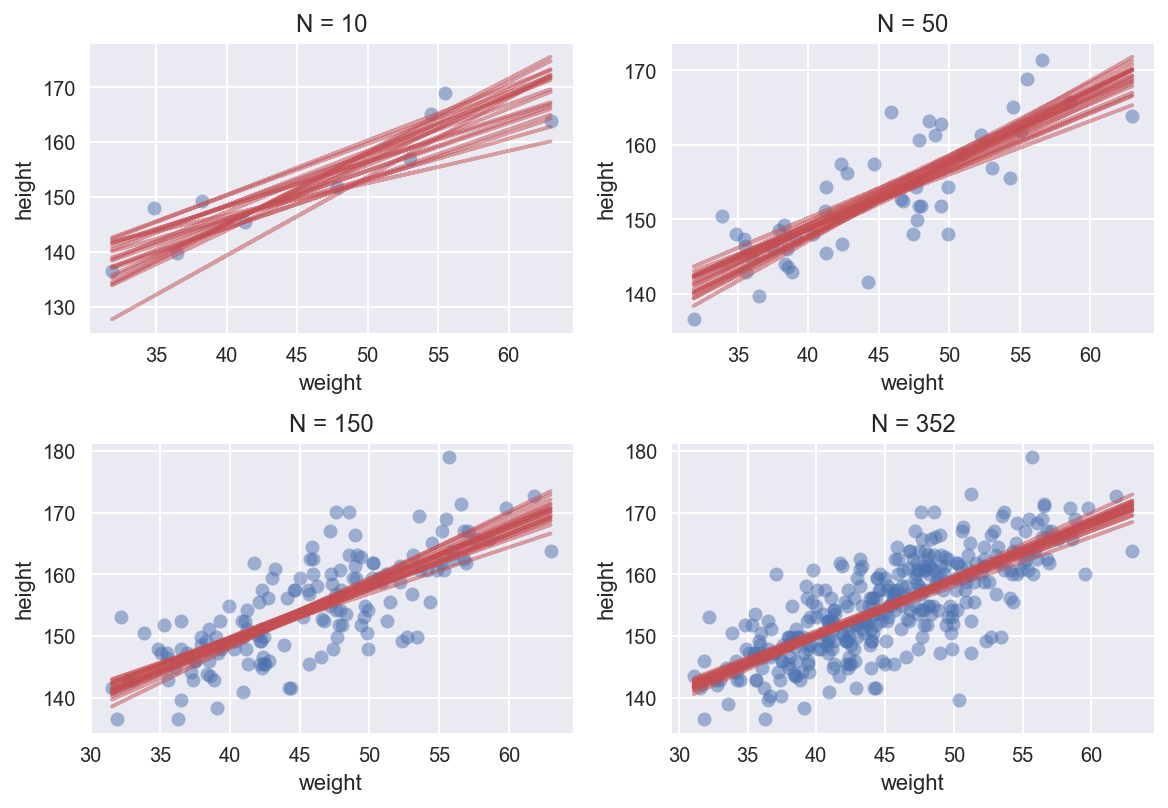

In [462]:
# Some additional code (copied from SO) to make the subplot loop work.
fig, axes = plt.subplots(2, 2, constrained_layout=True)
axes = axes.ravel()

# Code 4.49

for i, n in enumerate(N):
    # Plot the raw data
    axes[i].plot(adults.weight[:n], adults.height[:n], 'C0o', alpha = 0.5)
    for _ in range(0, 20):
        # Sample 20 random lines from the posterior
        idx = np.random.randint(len(chains['chain_' + str(i)]))
        # Plot the 20 lines from the posterior stored in the `chains` dict
        axes[i].plot(adults.weight[:n], 
                 chains['chain_' + str(i)]['alpha'][idx] # alpha
                     + chains['chain_' + str(i)]['beta'][idx] # + beta
                     * adults.weight[:n], # * weight
                 'C2-', 
                 alpha=0.5)
        axes[i].set_title('N = ' + str(n))
        axes[i].set_xlabel(adults.columns[1])
        axes[i].set_ylabel(adults.columns[0])


# For my own reference, the code above with `enumerate` is equivalent to the code below
# where I've had to do "for i in range(len(N)) and then call N[i]"
        
# for i in range(len(N)):
#     # Plot the raw data
#     axes[i].plot(adults.weight[:N[i]], adults.height[:N[i]], 'C0o', alpha = 0.5)
#     for _ in range(0, 20):
#         # Sample 20 random lines from the posterior
#         idx = np.random.randint(len(chains['chain_' + str(i)]))
#         # Plot the 20 lines from the posterior stored in the `chains` dict
#         axes[i].plot(adults.weight[:N[i]], 
#                  chains['chain_' + str(i)]['alpha'][idx] # alpha
#                      + chains['chain_' + str(i)]['beta'][idx] # + beta
#                      * adults.weight[:N[i]], # * weight
#                  'C2-', 
#                  alpha=0.5)
#         axes[i].set_title('N = ' + str(N[i]))
#         axes[i].set_xlabel(adults.columns[1])
#         axes[i].set_ylabel(adults.columns[0])

It can be seen clearly from these plots that as we increase the amount of data that we use to  fit the model, the narrower our estimate of the mean.

Notice also that there is greater uncertainty at the extremes. This is almost always so, as there is less data around the extremes and therefore greater variance between models.

**This is just a qualitative way of looking at uncertainty. In the section below we'll use some slightly more complicated methods to create credible interval ribbons from the HPDI.**

***

#### Digression about "sampling"

In Plot 2 it appears that we pulled a bunch of data (lines) out of thin air. In frequentist statistics we will often use *sampling* in order to gather data to quantify uncertainty.

It is important to keep in mind that in our Bayesian model when we are *sampling* we are not generating new data. Sampling is used as a heuristic to solve an intractable integration problem:

**Theory**: The posterior distribution consists of an infinite number of lines. To get the MAP line we would integrate over the entire posterior.

**Reality**: The "posterior distribution" is just an approximation of the theoretical posterior distribution. We use sampling techniques like MCMC to compute (say) 1,000 lines. We can further sample from these lines (like a frequentist would) in order to quantify uncertainty.

***

#### Plot 3

A third method that is not yet mentioned in the book is to plot the traces of the MCMC model.

**On the left** you can see the posterior distribution for each of the parameters---this just the probability density distribution for each (individual) parameter when all samples are considered. Note that here each of the parameters are uncoupled (e.g., if low $\alpha$ is associated with high $\beta$ we wouldn't see that here).

**On the right** the sample value at each step of the chain is given. This provides information about diagnosing the model rather than interpreting the model. You aim to see that the traces vary but have a stable centre.

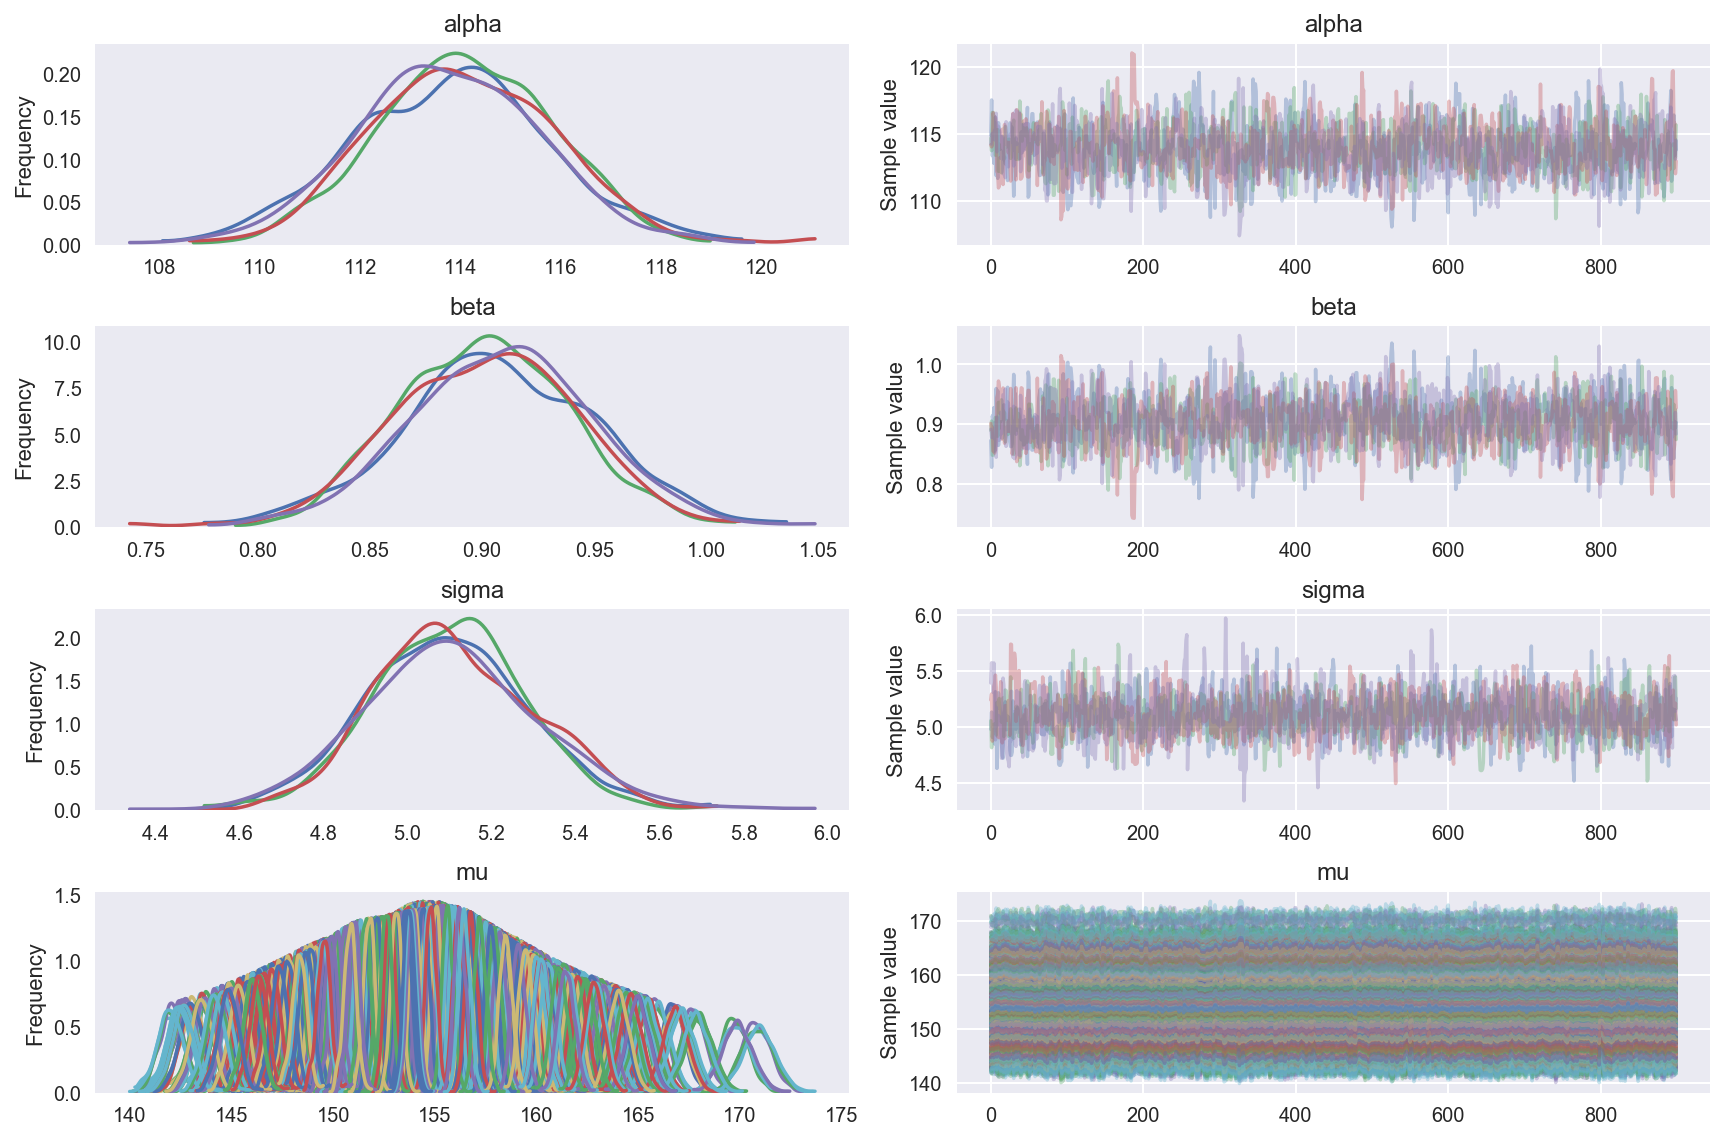

In [463]:
pm.traceplot(chain);

***

## 3.3 Interpreting the data

### 3.3.1 Predicting the mean with Credible Intervals

Now that we have looked at our model fit we may begin looking at the results of our model.

For example, we can compute the posterior distribution of height for a given a set of predictors. Eg., the mean height of individuals that weight 50kg.

This is easy to do in PyMC3. The trace of our model contains 1000 samples (or however many samples we chose to take) of $\alpha$, $\beta$, and $\sigma$ pairs. We can operate on them just like a data frame to calculate $\mu$.

Recall that because $\alpha$ and $\beta$ are Normally distributed parameters $\mu$, although it is a deterministic variable, will also follow a Normal distribution.

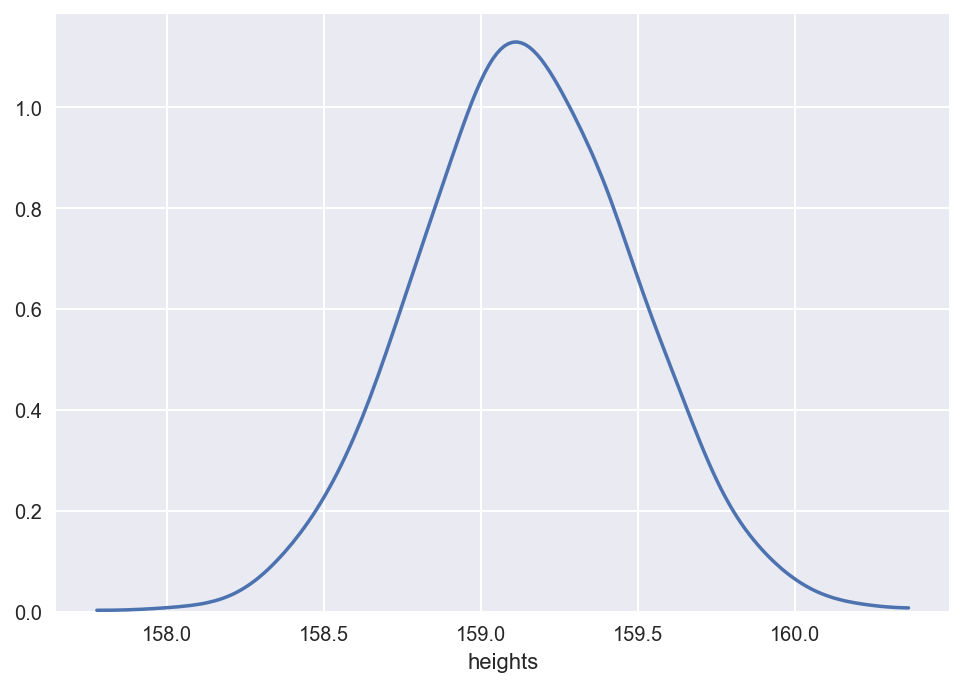

In [464]:
# Code 4.50 and 4.51
mu_at_50 = chain['alpha'] + chain['beta'] * 50

pm.kdeplot(mu_at_50)
plt.xlabel('heights');

As before, we can easily calculate the HDPI:

In [465]:
# Code 4.52

pm.hpd(mu_at_50, alpha=.11)

array([158.5710927 , 159.66384044])

While it is great that we can calculate the distribution of $\mu$ when the weight is 50kg, what would be much more powerful would be to obtain this distribution for every value of weight over the x-axis.

While the book implements a different function in R to help obtain these values, we do not need to compute anything else when using PyMC3. By defining a deterministic variable $\mu$ in the model, we add that variable to the trace. Thus we get a matrix with row samples from the posterior and columns values of weights. We can access this matrix directly from the trace. We can also turn it into a DataFrame depending on what we need.

In [466]:
# Code 4.53

df_trace = pm.trace_to_dataframe(chain)

df_trace.filter(regex=('mu.*')).head()

mu__0       mu__1       mu__2       mu__3       mu__4       mu__5  \
0  156.658370  146.758938  142.724919  161.212109  150.941448  169.898861   
1  157.158287  147.765812  143.938378  161.478826  151.734133  169.720723   
2  157.101392  146.734344  142.509772  161.870233  151.114421  170.967318   
3  157.134920  146.887426  142.711572  161.848768  151.216992  170.840944   
4  157.187930  146.666255  142.378672  162.027901  151.111663  171.260672   

        mu__6       mu__7       mu__8       mu__9     ...         mu__342  \
0  148.293350  163.340487  145.348269  162.474287     ...      153.342060   
1  149.221646  163.498208  146.427384  162.676366     ...      154.011808   
2  148.341236  164.099149  145.257040  163.192032     ...      153.628431   
3  148.475788  164.051979  145.427158  163.155323     ...      153.702010   
4  148.297114  164.290062  145.166916  163.369415     ...      153.663169   

      mu__343     mu__344     mu__345     mu__346     mu__347     mu__348  \
0  156.707867  149.308042  150.743460  150.545471  155.965410  144.803800   
1  157.205250  150.184374  151.546283  151.358434  156.500814  145.910798   
2  157.153227  149.403859  150.907081  150.699740  156.375698  144.686852   
3  157.186158  149.526156  151.012042  150.807093  156.417596  144.863546   
4  157.240539  149.375586  150.901229  150.690796  156.451413  144.588224   

      mu__349     mu__350     mu__351  
0  160.444903  162.103058  160.766635  
1  160.750909  162.324149  161.056164  
2  161.066787  162.803268  161.403716  
3  161.054587  162.771042  161.387631  
4  161.212471  162.974852  161.554426  

[5 rows x 352 columns]

***

Thus we can fulfill our goal of calculating the posterior distribution of $\mu$ for each value of `weight` by implementing the following code.

Note that the code is implemented in the book using the function `link`, but it is done here manually.

In [467]:
# Just check the range of weights that are covered by our data.
print(np.min(adults.weight))
print(np.max(adults.weight))

31.071052
62.992589


In [468]:
# Code 4.54

# Define this as the range of weights for which we want to compute mu.
# This is wider than our actual weight range, but not by much--and I am copying the book.
weight_seq = np.arange(25, 71)

In [469]:
# Code 4.54

mu_pred = np.zeros((len(weight_seq), len(chain)*chain.nchains))

# Code 4.58
# Calculate mu_pred_i for every combination of i and w 
# i.e., every pair of alpha/beta with every weight)
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain['alpha'] + chain['beta'] * w

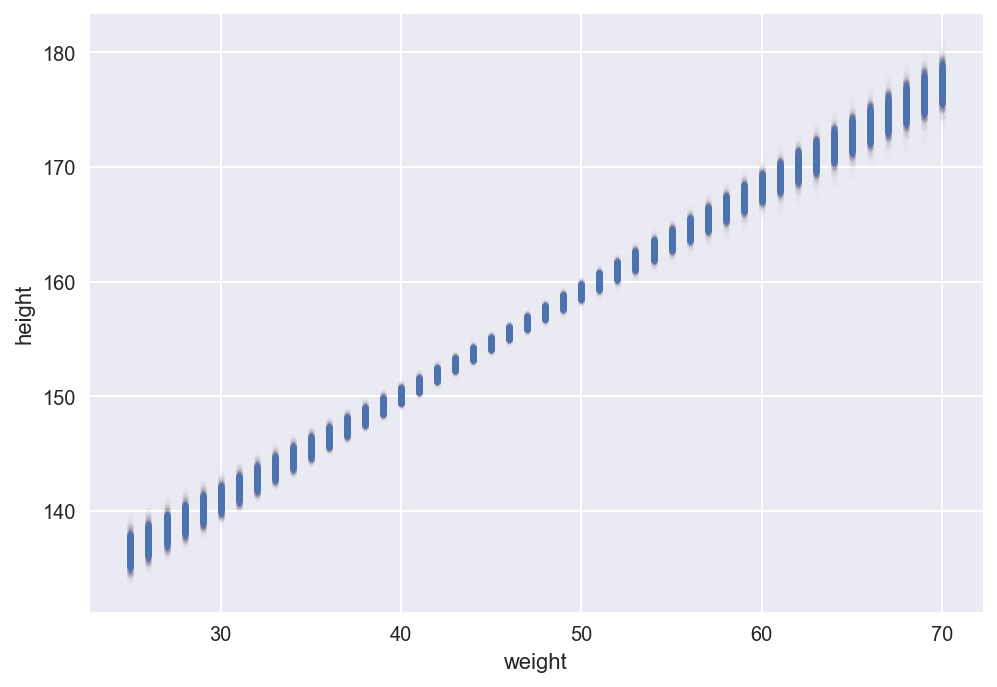

In [470]:
# Code 4.55

plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.002)
plt.xlabel('weight');
plt.ylabel('height');

# In the plot below, each dot represents a predicted $\mu$.
# At each weight (between 25 and 70), we've plotted the (sampled) posterior distribution 
# of `mu`.

***

The graph above is again a nice way to visualize uncertainty in the estimate, but it is hard to use this quantitatively. Similar to the way that we use confidence intervals in frequentist models, we can construct credible intervals (HPDI ribbons) in Bayesian models.

This is the exact same as Plot 2, but instead of plotting the lines we plot the 'plausible region' of lines.

#### Code 4.57

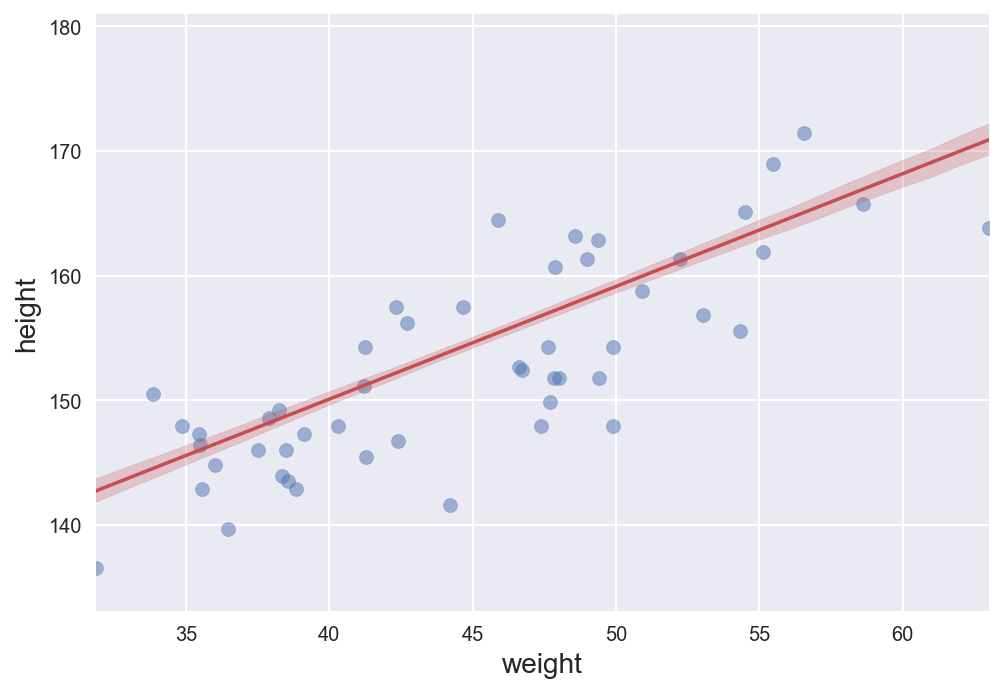

In [471]:
N = [10, 50, 150, 352]
i = 1    # index position of N to plot

mu_mean = mu_pred.mean(1) # The mean of `mu` at each weight
mu_hpd = pm.hpd(mu_pred.T, alpha=.11)    # The 89% HPDI at each weight

# Plot the data
plt.scatter(adults.weight[:N[i]], adults.height[:N[i]], alpha = 0.5)
# Plot the MAP line
plt.plot(weight_seq, mu_mean, 'C2')
# Fill the HPDI interval
plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.xlim(adults.weight[:N[i]].min(), adults.weight[:N[i]].max());

***

#### Digression about Credible / Confidence Intervals

In the figure above, the credible interval is very narrow. That is, the *model* quite confident in the location of the *mean* of $\mu$.

There are two important things to keep in mind when interpreting these intervals

1. The credible interval (or confidence interval) relies on the assumptions of the model. If the relationship between weight and height is not linear then the model may be overly confident or downright wrong.

2. The credible interval tells about where we expect the *mean* of $\mu$ to appear. It doesn't tell us very much about where we might expect observations to appear (notice how the scatter of the blue dots is much wider than the red band). We still have not addressed $\sigma$, which is the next element that we need to make predictions about where new observations may appear. We address this in the section below with prediction intervals.

***

### 3.3.2 Predicting future observations with Prediction Intervals

Recall that our model for height is:

$height \sim Normal(\mu, \sigma)$

We can calculate prediction intervals from the *Posterior Predictive Distribution*, which is the distribution of *unobserved* (i.e., simulated) data conditioned on the observed data. That is to say that it is the distribution of the outcome variable (height) that is computed from the posterior distributions of each parameter ($\alpha$, $\beta$, $\sigma$).

When we computed the MAP line and credible intervals, we calculated $\mu$ using all $\alpha$ and $\beta$ pairs for all of the observed weights using `enumerate()`. To calculate prediction intervals we do the same, but we also include the matching $\sigma$ for each line.

However, instead of writing the code manually, we can use the PyMC3 function `sample_ppc()` (Posterior Predictive Check). This function give us posterior predictive samples (i.e., samples from the Posterior Predictive Distribution).

Given samples from the PPC, we can calculate the HPDI corresponding to the prediction interval, just as we used samples of $\mu$ to calculate the HPDI corresponding to the credible interval.

In [472]:
# Code 4.59

height_pred = pm.sample_ppc(chain, 1000, m_N)

height_pred['height_hat'].shape

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1692.92it/s]


(1000, 352)

```sample_ppc``` returns values corresponding to the input values (weights in this example). Because the weights are not ordered if we use them with the ```fill_between``` function we will get a mess. For that reason in the following cell we order the weights and the predicted heights

In [474]:
# Code 4.60

height_pred_hpd = pm.hpd(height_pred['height_hat'])

idx = np.argsort(adults.weight.values[:N[i]])
adults_weight_ordered = adults.weight.values[:N[i]][idx]
height_pred_hpd = height_pred_hpd[idx]

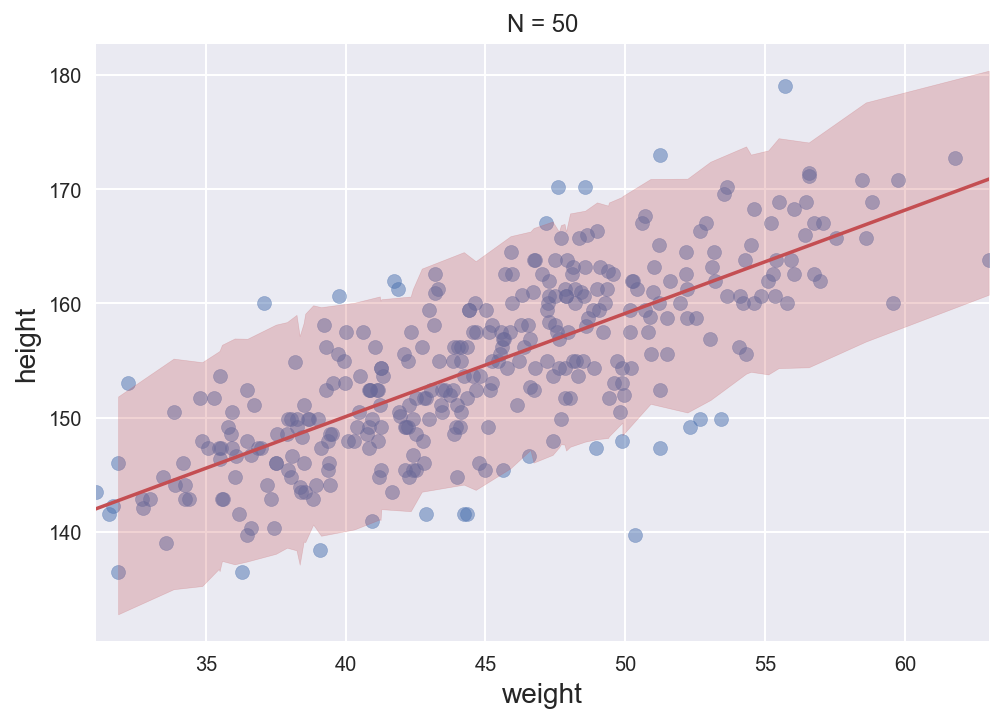

In [475]:
# Code 4.61

plt.scatter(adults.weight, adults.height, alpha = 0.5)
# plt.fill_between(weight_seq, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(adults_weight_ordered, height_pred_hpd[:,0], height_pred_hpd[:,1], color='C2', alpha=0.25)
plt.plot(weight_seq, mu_mean, 'C2')
plt.xlabel('weight', fontsize=14)
plt.ylabel('height', fontsize=14)
plt.title('N = {}'.format(str(N[i])))

plt.xlim(adults.weight.min(), adults.weight.max());

***

# Exercises

## Easy

**4E1**. In the model defnition below, which line is the likelihood?

a) $y_i \sim Normal(\mu, \sigma)$

b) $\mu \sim Normal(0, 10)$

c) $\sigma \sim Uniform(0, 10)$

(a) is the likelihood.


***

**4E2.** In the model defnition just above, how many parameters are in the posterior distribution?

2 parameters are in the posterior.


***

**4E3.** Using the model defnition above, write down the appropriate form of Bayes’ theorem that includes the proper likelihood and priors.

I think:

$$P(y_i|\mu,\sigma) = \frac{P(\mu,\sigma|y_i) P(y_i)}{P(\mu,\sigma)}$$

***

**4E4.** In the model defnition below, which line is the linear model?

a) $y_i \sim Normal(\mu; \sigma)$

b) $\mu_i = \alpha + \beta x_i$

c) $\alpha \sim Normal(0, 10)$

d) $\beta \sim Normal(0, 1)$

e) $\sigma \sim Uniform(0, 10)$

(b) is the linear model

***

**4E5.** In the model defnition just above, how many parameters are in the posterior distribution?

3 parameters (alpha, beta, sigma)

***

## Medium

**4M1.** For the model defnition below, simulate observed heights from the prior (not the posterior).

$y_i \sim Normal(\mu, \sigma)$

$\mu \sim Normal(0, 10)$

$\sigma \sim Uniform(0, 10)$

In [255]:
# Priors can be treated just like the posterior, so we can take samples from the
# priors and use them to calculate heights.
size = 10000
mu = np.random.normal(0, 10, size=size)
sigma = np.random.uniform(0, 10, size=size)

y = np.random.normal(mu, sigma, size=size)

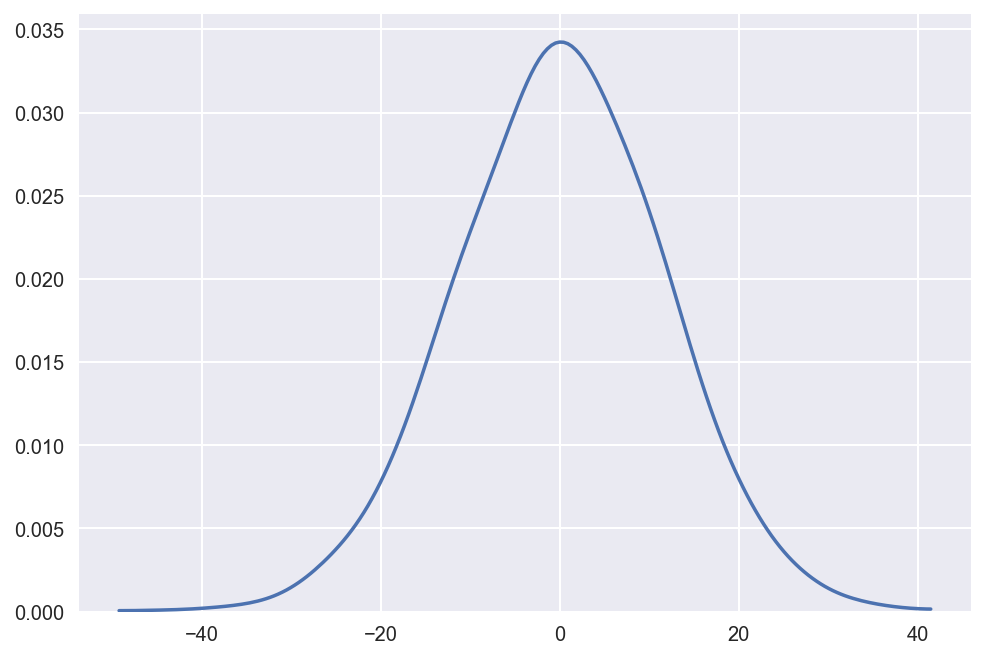

In [260]:
pm.kdeplot(y);

***

**4M2.** Translate the model just above into a map formula

In [225]:
with pm.Model() as model_4m1:
    mu = pm.Normal('mu', 0, 10)
    sigma = pm.Uniform('sigma', 0, 10)
    y = pm.Normal('y', mu, sigma)

***

**4M3.** Translate the map model formula below into a mathematical model defnition.

In [237]:
x = 0    # Normally x would be data.

with pm.Model() as model_4m3:
    a = pm.Normal('a', 0, 50)
    b = pm.Uniform('b', 0, 10)
    mu = pm.Deterministic('mu', a + b * x)
    sigma = pm.Uniform('sigma', 0, 10)
    y = pm.Normal('y', mu, sigma)

$\alpha \sim Normal(0, 50)$

$\beta \sim Uniform(0, 10)$

$\mu_i = \alpha + \beta x_i$

$\sigma \sim Uniform(0, 10)$

$y_i \sim Normal(\mu; \sigma)$



***

**4M4.** A sample of students is measured for height each year for 3 years. Afer the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model defnition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors.

**Likelihood**: Height is almost always approximately Normal, so I will use that as the likelihood. 

**Alpha**: Since we don't know the age of the students I will use a very weak prior for the mean height. Mean height obviously has finite variance, so I will model the prior with a Normal distribution. If I interpret "student" to mean someone young, I can set the mean of this distribution at 120cm. However, I still want a very wide distribution (large sd) since I don't know their ages. Still, there should be no probability (or extremely low probability) of having negative height.

**Beta**: It is reasonable to think that students will grow with age. Unless they are adult students (which they could be), they would not shrink. Still, I have no idea *how much* they might grow each year. 1cm, 10cm, 20cm? For now I will assume that students (on average) will not shrink, so I will represent $\beta$ with a half-Cauchy centred at 0. 

If this produces strange results I always have the option of revising my prior to include the possibility for negative growth.

**Sigma**: I have no real preconceptions about what $\sigma$ should be. I will keep it wide, but still avoid having negative heights.


The model definition would be as follows:

$height_i \sim Normal(\mu, \sigma)$

$\alpha \sim Normal(120, 40)$

$\beta \sim Half Cauchy(0, 10)$

$\sigma \sim Uniform(0, 40)$

$\mu = \alpha + \beta * year$

***

**4M5.** Now suppose I tell you that the average height in the frst year was 120 cm and that every student got taller each year. Does this information lead you to change your choice of priors? How?

Slightly, but not by much. This would change how the prior for $\alpha$ is centred.

I had already assumed that the mean growth of students was always positive; with the new information I might revise the $\beta$ prior to be centred at 0.1 instead of 0.

***

**4M6.** Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

I might revise the upper bound of my $\sigma$ prior to be $\sqrt(64) = 8$.

Taking this even further, I may say that it is reasonable to assume that a variance as high as 64 is less common than a lower variance, so I might use a half-Cauchy or Normal distribution to model $\sigma$. 

***

## Hard

**4H1.** The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals (either HPDI or PI) for each of these individuals.

The heights are provided in the code cell below.

In [317]:
heights_4h1 = pd.DataFrame({'weight': [46.95, 43.72, 64.78, 32.59, 54.63],
                          'expected_height': np.zeros(5),
                          'hdpi_89_lower': np.zeros(5),
                          'hdpi_89_upper': np.zeros(5)})

heights_4h1

weight  expected_height  hdpi_89_lower  hdpi_89_upper
0   46.95              0.0            0.0            0.0
1   43.72              0.0            0.0            0.0
2   64.78              0.0            0.0            0.0
3   32.59              0.0            0.0            0.0
4   54.63              0.0            0.0            0.0

In [269]:
# Let's start from the beginning and redefine our model of height for the adults.
with pm.Model() as model_4H1:
    alpha = pm.Normal('alpha', 178, 100)
    beta = pm.Normal('beta', 0, 10)
    mu = pm.Deterministic('mu', alpha + beta * adults.weight)
    sigma = pm.Uniform('sigma', 0, 50)
    height = pm.Normal('height', mu, sigma, observed = adults.height)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:07<00:00, 1007.47draws/s]


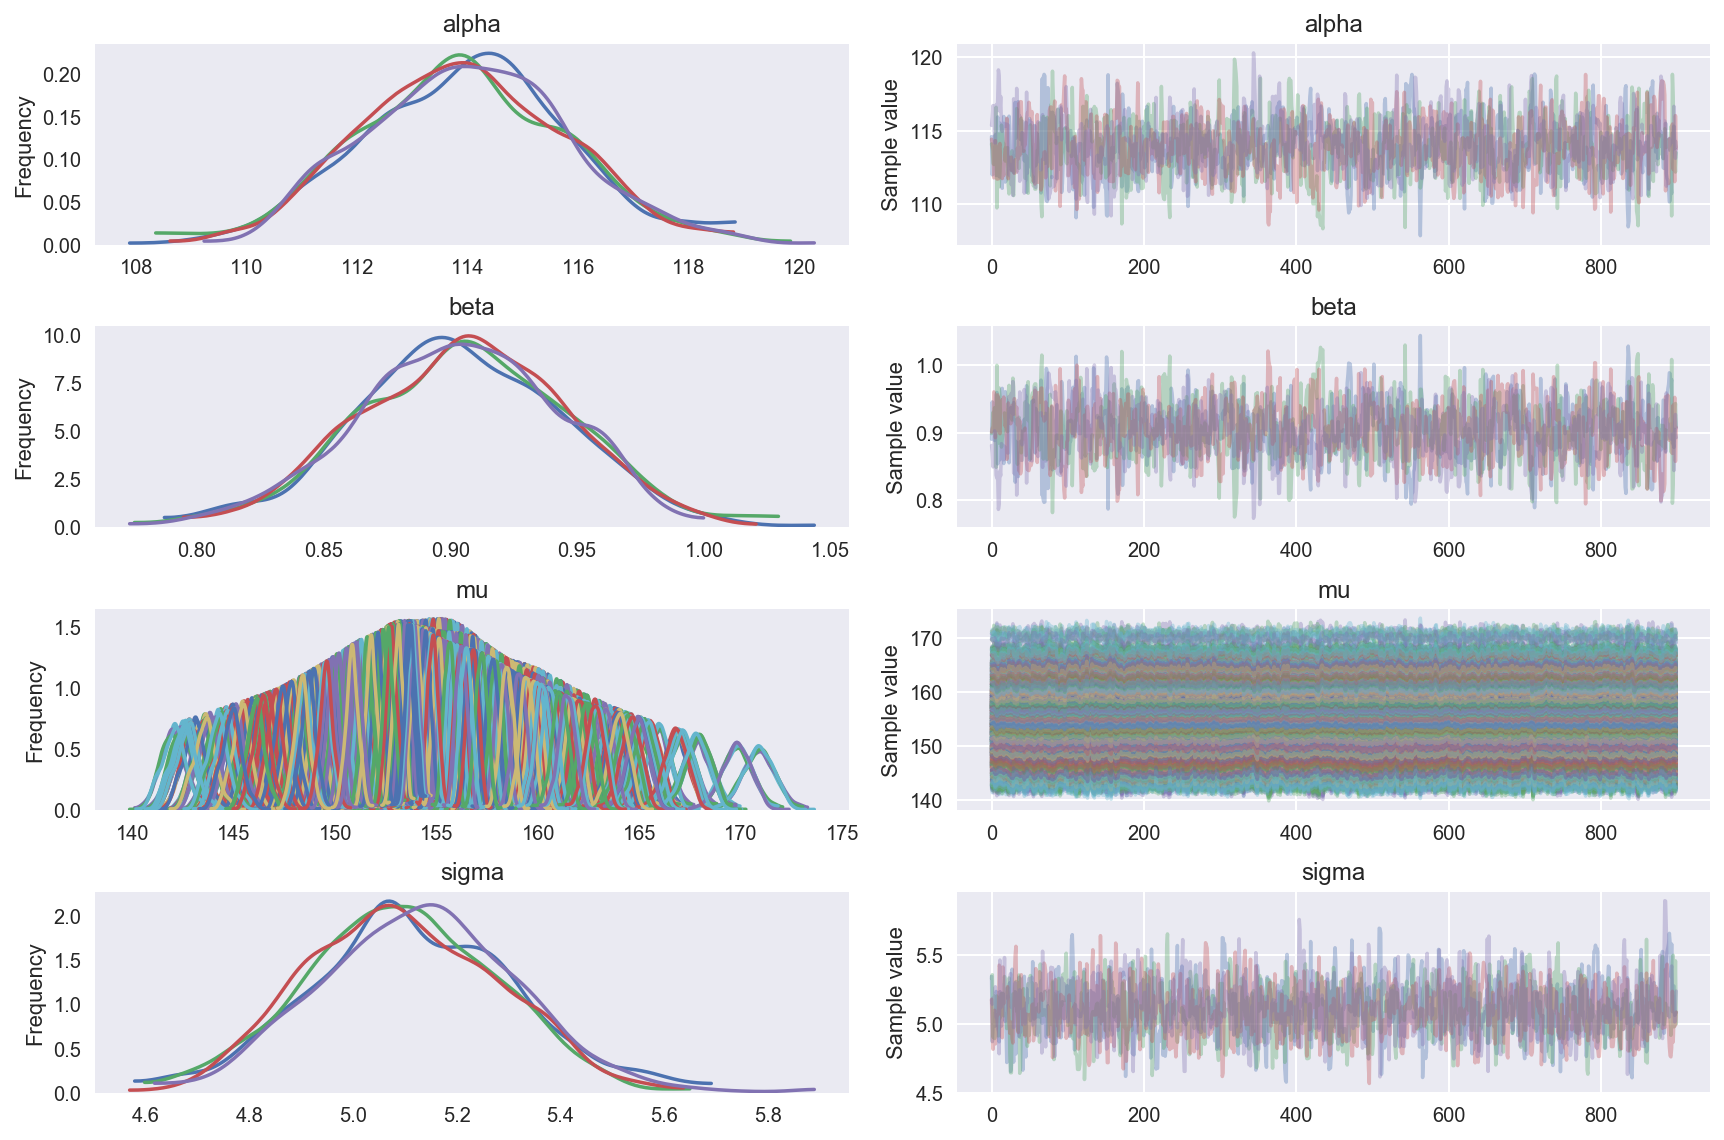

In [270]:
# Now we'll apply MCMC to generate samples from the posterior
with model_4H1:
    trace_4H1 = pm.sample(1000, tune=1000)
    
chain_4H1 = trace_4H1[100:]

pm.traceplot(chain_4H1);

Expectation:
156.36533200768042


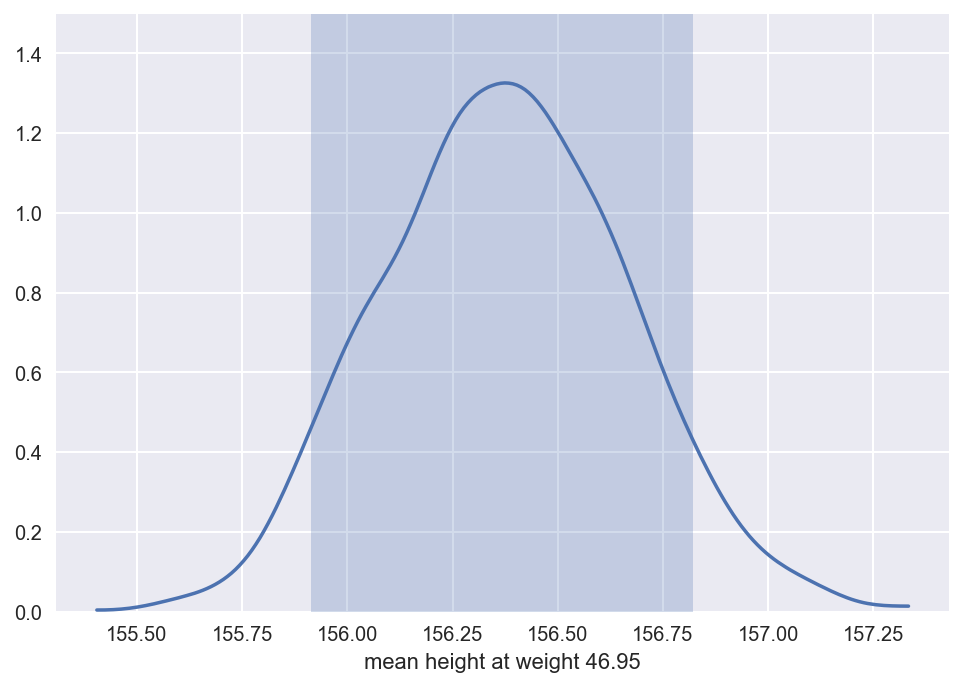

In [308]:
# Our posterior (chain) contains samples of alpha and beta parameters.
# We can calculate the height for each pair of the sample coefficients

# We can calculate the expectation and HPDI for a given weight as follows:
mu_at_weight_4H1 = chain_4H1['alpha'] + chain_4H1['beta'] * heights_4h1.weight[0]


print('Expectation:')
print(mu_at_weight_4H1.mean())

# Plot:
pm.kdeplot(mu_at_weight)
plt.xlabel('mean height at weight {}'.format(heights_4h1.weight[0]));
plt.fill_betweenx(y=[0,1.5],
                  x1=pm.hpd(mu_at_weight_4H1, alpha = 0.11)[0], 
                  x2=pm.hpd(mu_at_weight_4H1, alpha = 0.11)[1],
                 alpha = 0.25)
plt.ylim(0,1.5);

In [283]:
# Here is some code to calculate all of the posterior prectives at once

# Define the length required for the mu_pred veriable that will store the results
mu_pred_4H1 = np.zeros((len(heights_4h1.weight), len(chain_4H1) * chain_4H1.nchains))

# Calculate the posterior predictive for each of the weights in the table
for i, weight in enumerate(heights_4h1.weight):
    mu_pred_4H1[i] = chain_4H1['alpha'] + chain_4H1['beta'] * weight

In [313]:
mu_pred_4H1.shape

(5, 3600)

In [319]:
# Here is the code to fill in the table all at once (there is probably a more efficient
# way to do this)

for i in range(0, 5):
    heights_4h1['expected_height'][i] = mu_pred_4H1[i].mean()
    heights_4h1['hdpi_89_lower'][i] = pm.hpd(mu_pred_4H1[i], alpha = 0.11)[0]
    heights_4h1['hdpi_89_upper'][i] = pm.hpd(mu_pred_4H1[i], alpha = 0.11)[1]
    
heights_4h1

weight  expected_height  hdpi_89_lower  hdpi_89_upper
0   46.95       156.365332     155.914759     156.820978
1   43.72       153.445477     153.006817     153.870915
2   64.78       172.483296     171.128174     173.874120
3   32.59       143.384179     142.474234     144.273242
4   54.63       163.307899     162.544431     164.107733

***

**4H2.** Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

In [320]:
kids = dat[dat.age < 18]

kids.shape

(192, 4)

(a) Fit a linear regression to these data, using map. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

In [335]:
# Define the model:
# I have chosen slightly different priors from the adult model (alpha is smaller)

with pm.Model() as model_4H2:
    alpha = pm.Normal('alpha', 100, 30)
    beta = pm.Normal('beta', 0, 10)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', alpha + beta * kids.weight)
    height = pm.Normal('height', mu, sigma, observed = kids.height)

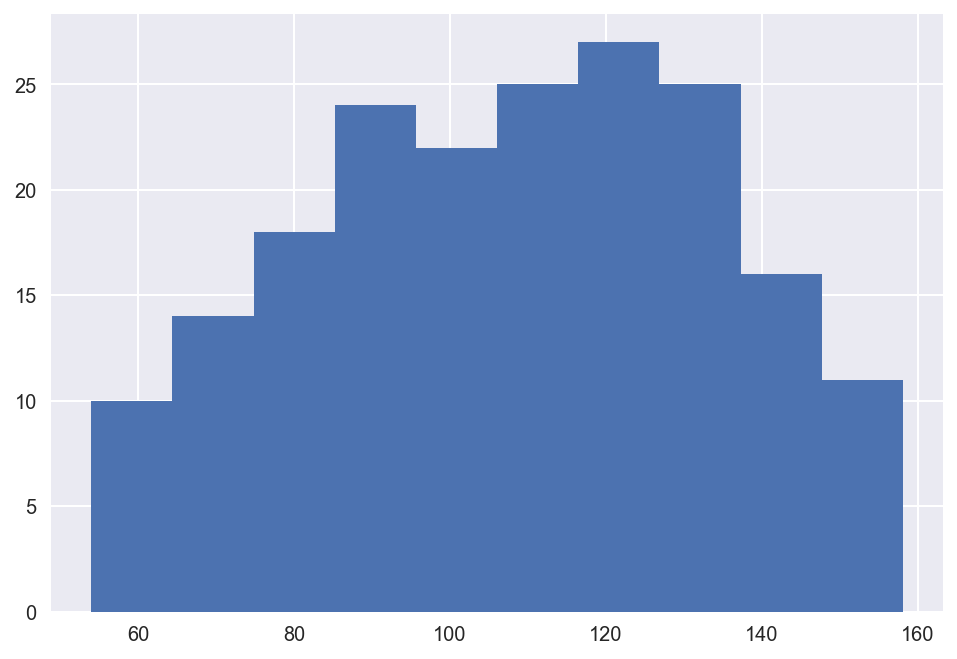

In [336]:
# First let's plot the raw data:
plt.hist(kids.height);

In [333]:
# Now we'll apply MCMC to generate samples from the posterior
with model_4H1:
    trace_4H1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:08<00:00, 946.70draws/s]
The acceptance probability does not match the target. It is 0.8901211395876297, but should be close to 0.8. Try to increase the number of tuning steps.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1359.12draws/s]


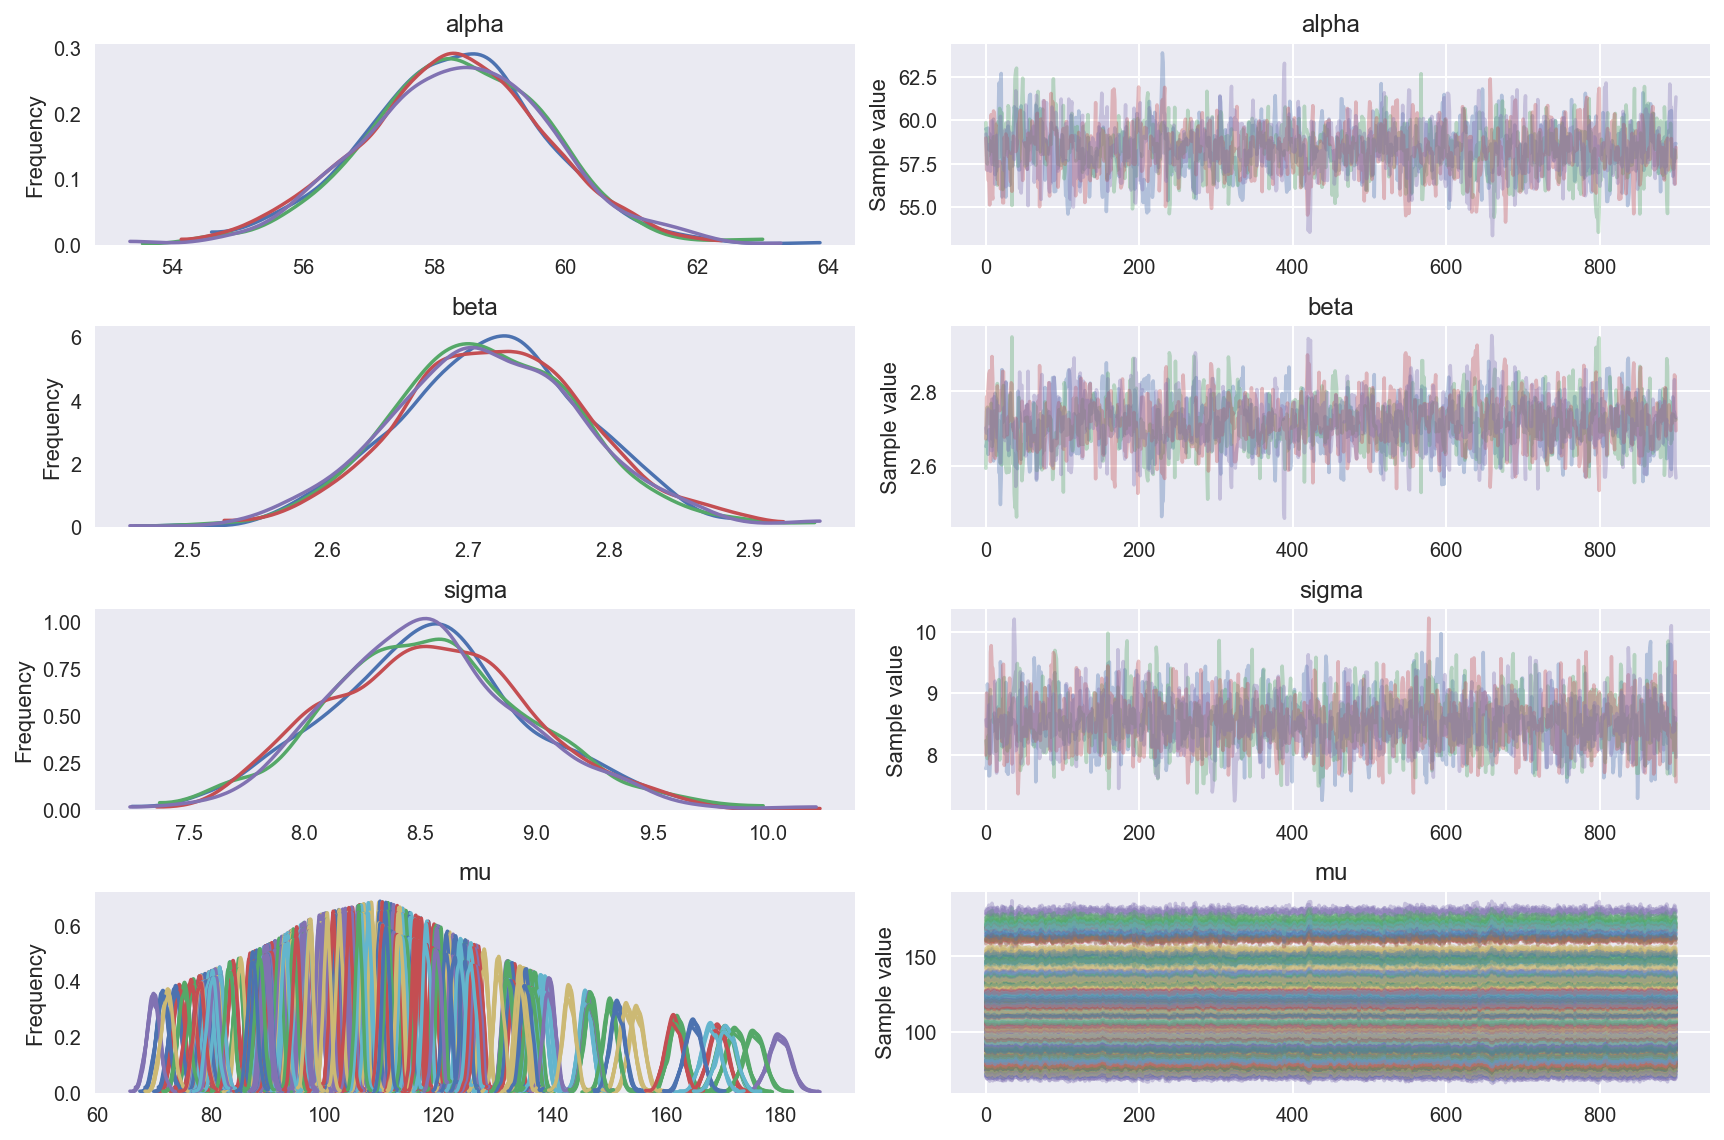

In [342]:
# Compute the posterior by MCMC
with model_4H2:
    trace_4H2 = pm.sample(1000, tune=1000)

chain_4H2 = trace_4H2[100:]

pm.traceplot(chain_4H2);

In [351]:
# Print the estimates
print(pm.trace_to_dataframe(chain_4H2).mean()[:3])

alpha    58.317985
beta      2.715687
sigma     8.531739
dtype: float64


The mean increase in height for every 10kg increase in weight is 27cm. This seems quite high and likely would not be the same for adults.

***

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% HPDI for the mean. Also superimpose the 89% HPDI for predicted heights.

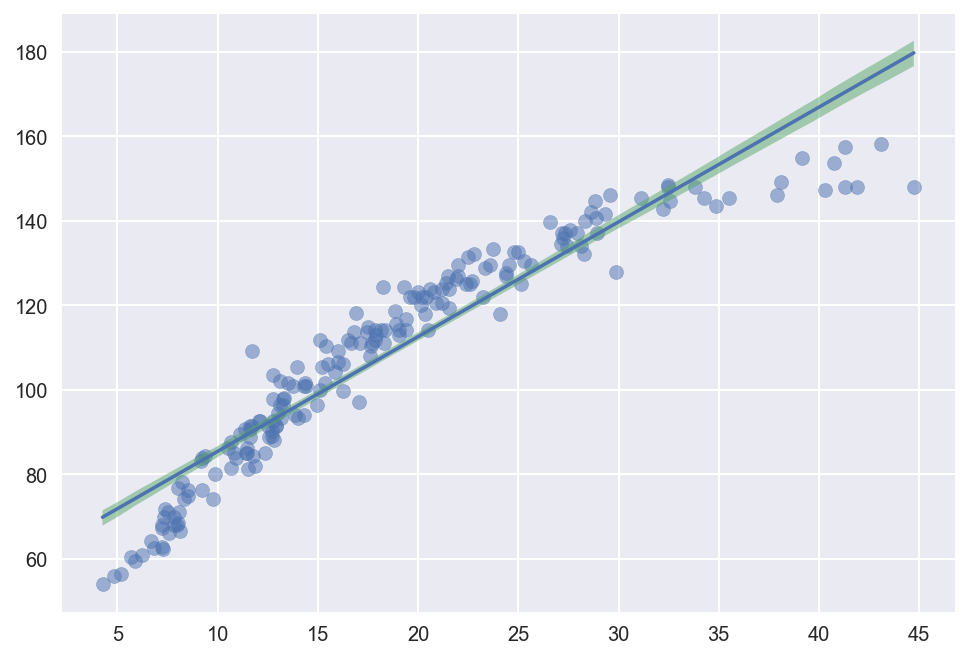

In [391]:
# Calculate the MAP
weight_seq = np.linspace(kids.weight.min(), kids.weight.max())    # calculate heights for over range of all observed weights
mu_pred_4H2 = np.zeros((len(weight_seq), len(chain_4H2)*chain_4H2.nchains))

for i, weight in enumerate(weight_seq):
    mu_pred_4H2[i] = chain_4H2['alpha'] + chain_4H2['beta'] * weight

map_4H2 = mu_pred_4H2.mean(axis=1)


# Calculate the HPDI
hpdi_4H2 = pm.hpd(mu_pred_4H2.T, alpha = 0.11)

# Plot the data
plt.scatter(x=kids.weight, y=kids.height, alpha = 0.5)

# Plot the MAP
plt.plot(weight_seq, map_4H2)

# Plot the HPDI
plt.fill_between(weight_seq, hpdi_4H2[:, 0], hpdi_4H2[:, 1], alpha = 0.5)

***

(c) What aspects of the model ft concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

Height and weight do not have a linear relationship. As weight increases, height plateaus.

A different type of regression may do better, such as if non-linear terms (eg., polynomial) were added.

***

**4H3.** Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Fit this model, using quadratic approximation:

a) $y_i \sim Normal(\mu; \sigma)$

b) $\mu_i = \alpha + \beta log(x_i)$

c) $\alpha \sim Normal(178, 100)$

d) $\beta \sim Normal(0, 100)$

e) $\sigma \sim Uniform(0, 50)$


where $h_i$ is the height of individual $i$ and $w_i$ is the weight (in kg) of individual $i$. The function for computing a natural log in R is just log. Can you interpret the resulting estimates?

In [500]:
# As I have already gone through several examples step-by-step I will do this one in one go.

# Define model
with pm.Model() as model_4H3:
    alpha = pm.Normal('alpha', 178, 100)
    beta = pm.Normal('beta', 0, 100)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', alpha + beta * np.log(dat.weight))
    height = pm.Normal('height', mu, sigma, observed = dat.height)
    
    trace_4H3 = pm.sample(1000, tune=1000)
    chain_4H3 = trace_4H3[100:]
    
# Normally I would generate a trace plot but I will ignore that here to save space.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 8000/8000 [00:08<00:00, 961.34draws/s]
The acceptance probability does not match the target. It is 0.8805447579206013, but should be close to 0.8. Try to increase the number of tuning steps.


***

(b) Use samples from the quadratic approximate posterior of the model in (a) to superimpose on a plot: 

(1) the predicted mean height as a function of weight, 

(2) the 97% HPDI for the mean, and

(3) the 97% HPDI for predicted heights.

In [519]:
# (1) Predicted mean
weight_seq = np.linspace(dat.weight.min(), dat.weight.max())
mu_pred_4H3 = np.zeros((len(weight_seq), len(chain_4H3)*chain_4H3.nchains))

for i, weight in enumerate(weight_seq):
    mu_pred_4H3[i] = chain_4H3['alpha'] + chain_4H3['beta'] * np.log(weight)

map_4H3 = mu_pred_4H3.mean(axis=1)


# (2) HPDI for the mean
hpdi_4H3_mean = pm.hpd(mu_pred_4H3.T, alpha = 0.001)

# (3) HPDI for the predicted heights:

# Sample from the predctive posterior
hpdi_4H3_pred = pm.sample_ppc(chain_4H3, 1000, model_4H3)

# Compute the HPDI for heights on the predictive posterior samples
hpdi_4H3_pred_height = pm.hpd(hpdi_4H3_pred['height'], alpha = 0.001)

# Sort the weight and predicted height values so that the ribbon displays correctly
idx = np.argsort(dat.weight.values)
dat_weight_ordered = dat.weight.values[idx]
hpdi_4H3_pred_height = hpdi_4H3_pred_height[idx]

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1745.42it/s]


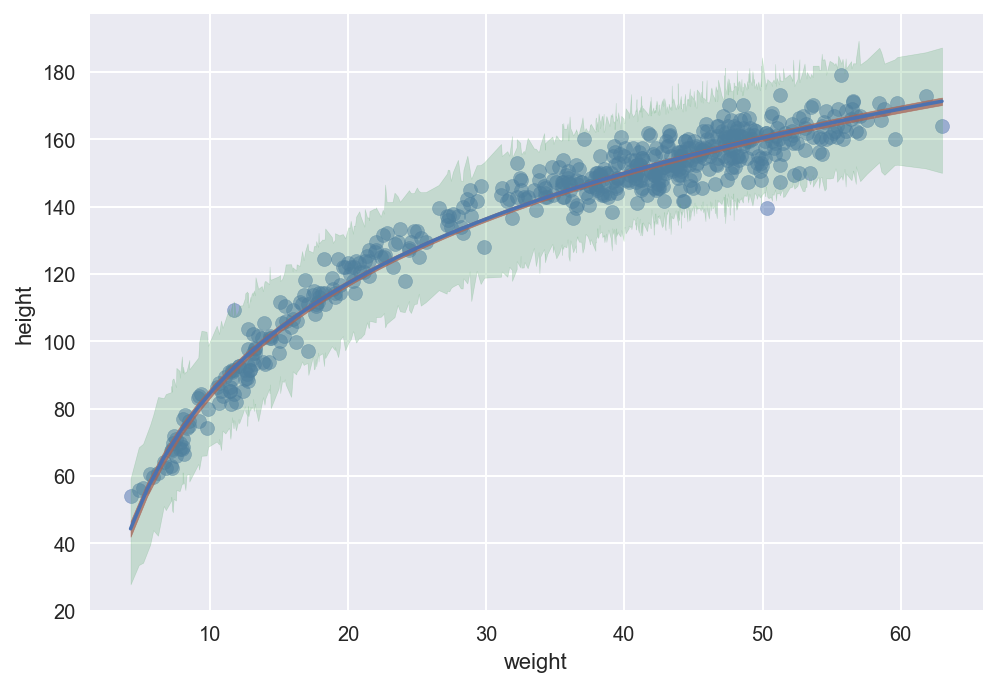

In [522]:
# Displaying the 99.9% HPDI intervals so that the credible interval for the mean is actually visible.

plt.scatter(dat.weight, dat.height, alpha = 0.5)
plt.plot(weight_seq, map_4H3)
plt.fill_between(weight_seq, hpdi_4H3_mean[:, 0], hpdi_4H3_mean[:, 1], alpha = 0.75, color='C2')
plt.fill_between(dat_weight_ordered, hpdi_4H3_pred_height[:, 0], hpdi_4H3_pred_height[:, 1], alpha = 0.25, color='C1')
plt.xlabel('weight')
plt.ylabel('height');

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))